## Python Implementation of the Hartree Fock Method

THIS NOTEBOOK IS UNDER CONSTRUCTION

### Introduction

Hartree Fock (HF) is the simplest electronic structure method and serves as a foundation for other more complex and accurate approximations (so-called post-HF methods). And as such is the ideal example on which to explore the process of quantum chemical computation. 

The HF method attempts to approximate the wave function of a many-body system, which in turn allows us to obtain desired expecation values of the system, such as energy.

In HF we assume that the exact $N$-electron wavefunction can be approximated by a single Slater determinant $\psi_{SD}$. The aim is then to find $\psi_{SD}$ which has the lowest energy expectation value $E_{SD}$ for a system of $n$ electrons, with respect to the given basis (set).

In [1]:
import numpy as np
import scipy as sp
import os, sys
import math
import json

def ReadInput(input_file):
    input=open(input_file,"r")
    angtobohr = 0.5291772109
    natoms=0
    z=[]
    i=0
    labels=[]
    charge=0

    for index,line in enumerate(input): 
        if index==1:
            natoms=int(line.split()[0]) 
            coords=np.zeros((natoms,3))
        if index==3:
            charge=int(line.split()[0])
        if index > 3 and index < (natoms+4):
            aux=line.split()
            atomic_name=aux[0]     #read and store the name of each atom
            if atomic_name == "H":
                atomic_num = 1
            if atomic_name == "He":
                atomic_num = 2
            coord=[float(aux[1])/angtobohr,float(aux[2])/angtobohr,float(aux[3])/angtobohr]
            labels.append(atomic_name) #we add the data (atom names) to a list
            z.append(atomic_num) # we add the data (atomic number) to a list
            coords[i,:]=coord  #we add the coordinates of each atom
            i=i+1
    return natoms,charge,labels,z,coords

def BuildBasis(natoms, atomic_numbers, coordinates, basis_set_name, basis_directory="basis/"):
    bfno = 0
    basis_set = []

    basis_file = os.path.join(basis_directory, f"{basis_set_name}.json")
    if not os.path.exists(basis_file):
        raise FileNotFoundError(f"Basis set file not found: {basis_file}")

    with open(basis_file, "r") as file:
        basis_data = json.load(file)

    for atom_idx, atomic_number in enumerate(atomic_numbers):
        if str(atomic_number) not in basis_data["elements"]:
            raise ValueError(f"Basis set not defined for atomic number {atomic_number}")

        element_basis = basis_data["elements"][str(atomic_number)]

        for shell in element_basis["electron_shells"]:
            angular_momentum = shell["angular_momentum"]
            exponents = [float(e) for e in shell["exponents"]]
            coefficients = [[float(c) for c in coeff_set] for coeff_set in shell["coefficients"]]

            for ang_mom_idx, ang_mom in enumerate(angular_momentum):
                basis_set.append(
                    [
                        bfno,  # Basis function index
                        atom_idx,  # Atom index
                        len(exponents),  # Number of primitives
                        exponents,  # Primitive exponents
                        coefficients[ang_mom_idx],  # Primitive coefficients
                        ang_mom,  # Angular momentum (e.g., s, p, d, ...)
                    ]
                )
                bfno += 1

    return bfno, basis_set

### Boys Function

```BoysFunc``` computes the Boys function $F_0(r)$. The Boys function is defined as:

$F_0(r)=\frac{1}{2}\sqrt{\frac{\pi}{r}} \text{erf}(\sqrt{r})$

This is a 'helper' function that we will need down the line when evaluating two-electron Coulomb integrals over our GTO's. 

Because when evaluating a two electron integral:

$\langle ij | kl \rangle = \int \int \phi_i (r_1) \phi_j (r_1) \frac{1}{|r_1 - r_2|} \phi_k (r_2) \phi_l (r_2) dr_1 dr_2$ 

where $\phi_n$ are basis functions and $r_n$ are electron coordinates, The interaction is dependent on explicit positions of two electrons ($r_1$, $r_2$). The Boys function replaces this by a dependency on the separation of Gaussian centers ($r$) and their 'spread' ($\rho$), thus providing some simplification of the computation.



In [2]:
def BoysFunc(r):
   xsmall = 1.e-6
   if r < xsmall:
      b = 1.
   else:
      b = 0.5 * np.sqrt(np.pi/r) * math.erf(np.sqrt(r))
   return b 

### One Electron Integrals

The aptly named ```compute_one_electron_integrals``` function calculates the terms involving only single-electron operators; **overlap integral matrix** ($S$), **kinetic energy integral matrix** ($T$) and **nuclear attraction integral matrix** ($V$).

This is done by iterating over pairs of basis functions and computing the contributions to the three aforementioned matrices by summing over the primitives of the GTO basis set.

#### Overlap Integral (S)
Overlap integral is simply a quantification of the spatial overlap between two basis functions. Written as:

$S_{ij} = \langle \phi_i | \phi_j \rangle = \int \phi_i (r) \phi_j (r) d^3r$

However in the code the form is a little different:
```py
gaussian_overlap = (
    coeff1
    * coeff2
    * (np.pi / p) ** (3 / 2)
    * np.exp(-q * distance_squared)
)
overlap_matrix[basis_fn1, basis_fn2] += gaussian_overlap
```

@TODO

#### Kinetic Energy Integral (T)

The kinetic energy matrix represents the expectation value of the kinetic energy operator for an electron:

$T_{ij} = - \frac{1}{2} \int \phi_i (r) \nabla^2 \phi_j(r) d^3 r$

In the code the kinetic energy integral is also weighted by the overlap of the two basis functions. 
@TODO why?

#### Nuclear Attraction Integral (V)

This term accounts for the Coulomb interaction between an electron and the nuclei:

$V_{ij} = - \sum_A Z_A \int \phi_i(r) \frac{1}{|r-R_A|} \phi_j(r) d^3 r$

where $Z_A$ is the nuclear charge of nucleus $A$ at position $R_A$

Here we also help ourselves with the Boys function as we can then neglect the exact positions of electrons and nuclei and just handle their relative positions. We then sum contributions from all nuclei in the system weighted by their atomic number $Z_A$

In [ ]:
def compute_one_electron_integrals(num_atoms, num_basis, atomic_numbers, coordinates, basis_set):
    overlap_matrix = np.zeros((num_basis, num_basis))
    kinetic_energy_matrix = np.zeros((num_basis, num_basis))
    nuclear_attraction_matrix = np.zeros((num_basis, num_basis))

    for basis_fn1 in range(num_basis):
        atom1_idx = basis_set[basis_fn1][1]
        atom1_coords = coordinates[atom1_idx, :]

        for basis_fn2 in range(num_basis):
            atom2_idx = basis_set[basis_fn2][1]
            atom2_coords = coordinates[atom2_idx, :]

            for prim1_idx in range(basis_set[basis_fn1][2]):
                zeta1 = basis_set[basis_fn1][3][prim1_idx]
                coeff1 = basis_set[basis_fn1][4][prim1_idx]

                for prim2_idx in range(basis_set[basis_fn2][2]):
                    zeta2 = basis_set[basis_fn2][3][prim2_idx]
                    coeff2 = basis_set[basis_fn2][4][prim2_idx]

                    p = zeta1 + zeta2
                    q = zeta1 * zeta2 / p
                    gaussian_center = (zeta1 * atom1_coords + zeta2 * atom2_coords) / p

                    distance_squared = np.linalg.norm(atom2_coords - atom1_coords) ** 2
                    gaussian_overlap = (
                        coeff1
                        * coeff2
                        * (np.pi / p) ** (3 / 2)
                        * np.exp(-q * distance_squared)
                    )

                    overlap_matrix[basis_fn1, basis_fn2] += gaussian_overlap

                    kinetic_contribution = q * (3.0 - 2.0 * q * distance_squared)
                    kinetic_energy_matrix[basis_fn1, basis_fn2] += kinetic_contribution * gaussian_overlap

                    attraction_term = 0.0
                    for nucleus_idx in range(num_atoms):
                        nucleus_coords = coordinates[nucleus_idx, :]
                        nucleus_distance_squared = np.linalg.norm(
                            nucleus_coords - gaussian_center
                        ) ** 2
                        boys_factor = BoysFunc(p * nucleus_distance_squared)
                        attraction_term += boys_factor * atomic_numbers[nucleus_idx]

                    nuclear_attraction_matrix[basis_fn1, basis_fn2] -= (
                        2.0 * attraction_term * np.sqrt(p / np.pi) * gaussian_overlap
                    )

    return overlap_matrix, kinetic_energy_matrix, nuclear_attraction_matrix

### Two Electron Integrals

Two-electron integrals are for the electron-electron repulsion:

$\langle ij | kl \rangle = \int \int \phi_i (r_1) \phi_j (r_1) \frac{1}{|r_1 - r_2|} \phi_k (r_2) \phi_l (r_2) dr_1 dr_2$ 

@TODO

In [4]:
def compute_two_electron_integrals(num_basis, coordinates, basis_set):
    two_electron_integrals = np.zeros((num_basis, num_basis, num_basis, num_basis))
    normalization_factor = np.sqrt(2.0) * (np.pi ** 1.25)

    for basis_fn1 in range(num_basis):
        atom1_idx = basis_set[basis_fn1][1]
        atom1_coords = coordinates[atom1_idx, :]

        for basis_fn2 in range(basis_fn1 + 1):
            atom2_idx = basis_set[basis_fn2][1]
            atom2_coords = coordinates[atom2_idx, :]
            distance12_squared = np.linalg.norm(atom2_coords - atom1_coords) ** 2

            for basis_fn3 in range(num_basis):
                atom3_idx = basis_set[basis_fn3][1]
                atom3_coords = coordinates[atom3_idx, :]

                for basis_fn4 in range(basis_fn3 + 1):
                    atom4_idx = basis_set[basis_fn4][1]
                    atom4_coords = coordinates[atom4_idx, :]
                    distance34_squared = np.linalg.norm(atom4_coords - atom3_coords) ** 2

                    if basis_fn1 * (basis_fn1 + 1) // 2 + basis_fn2 < basis_fn3 * (basis_fn3 + 1) // 2 + basis_fn4:
                        continue

                    integral_value = 0.0
                    for prim1_idx in range(basis_set[basis_fn1][2]):
                        zeta1 = basis_set[basis_fn1][3][prim1_idx]
                        coeff1 = basis_set[basis_fn1][4][prim1_idx]

                        for prim2_idx in range(basis_set[basis_fn2][2]):
                            zeta2 = basis_set[basis_fn2][3][prim2_idx]
                            coeff2 = basis_set[basis_fn2][4][prim2_idx]

                            p = zeta1 + zeta2
                            q = zeta1 * zeta2 / p
                            gaussian_center1 = (zeta1 * atom1_coords + zeta2 * atom2_coords) / p
                            factor12 = normalization_factor * np.exp(-q * distance12_squared) / p

                            for prim3_idx in range(basis_set[basis_fn3][2]):
                                zeta3 = basis_set[basis_fn3][3][prim3_idx]
                                coeff3 = basis_set[basis_fn3][4][prim3_idx]

                                for prim4_idx in range(basis_set[basis_fn4][2]):
                                    zeta4 = basis_set[basis_fn4][3][prim4_idx]
                                    coeff4 = basis_set[basis_fn4][4][prim4_idx]

                                    pk = zeta3 + zeta4
                                    qk = zeta3 * zeta4 / pk
                                    gaussian_center2 = (
                                        (zeta3 * atom3_coords + zeta4 * atom4_coords) / pk
                                    )
                                    factor34 = normalization_factor * np.exp(-qk * distance34_squared) / pk

                                    inter_center_distance_squared = np.linalg.norm(
                                        gaussian_center2 - gaussian_center1
                                    ) ** 2
                                    rho = p * pk / (p + pk)
                                    boys_factor = BoysFunc(rho * inter_center_distance_squared)

                                    integral_contribution = (
                                        boys_factor
                                        * factor12
                                        * factor34
                                        / np.sqrt(p + pk)
                                        * coeff1
                                        * coeff2
                                        * coeff3
                                        * coeff4
                                    )
                                    integral_value += integral_contribution

                    # Symmetry considerations
                    two_electron_integrals[basis_fn1, basis_fn2, basis_fn3, basis_fn4] = integral_value
                    two_electron_integrals[basis_fn2, basis_fn1, basis_fn3, basis_fn4] = integral_value
                    two_electron_integrals[basis_fn1, basis_fn2, basis_fn4, basis_fn3] = integral_value
                    two_electron_integrals[basis_fn2, basis_fn1, basis_fn4, basis_fn3] = integral_value
                    two_electron_integrals[basis_fn3, basis_fn4, basis_fn1, basis_fn2] = integral_value
                    two_electron_integrals[basis_fn4, basis_fn3, basis_fn1, basis_fn2] = integral_value
                    two_electron_integrals[basis_fn3, basis_fn4, basis_fn2, basis_fn1] = integral_value
                    two_electron_integrals[basis_fn4, basis_fn3, basis_fn2, basis_fn1] = integral_value

    return two_electron_integrals

### Core Hamiltonian, Initialization of the Density Matrix and Orthogonalization of the Overlap Matrix

In this part of the code we do a some setup before we start dealing with the Self-Consistent Field (SCF), itself.

`H_core`\
This is pretty straightforward, this functions is just an expression for the core Hamiltonian, which is the sum of the Kinetic energy integral and Potential energy integral (or electron-nuclear attraction):

$H_{core} = T + V$

`S_orthogonalized`\
This function orthogonalizes the overlap matrix $S$. This seems a little random, however it is necessary in the light of how coefficients for molecular orbitals are obtained in HF.

We obtain them by solving

$FC=SC\epsilon$

To simplify this into a standard eigenvalue proble, the overlap matrix is orthogonalizes such that:

$C' = CS^{-\frac{1}{2}}C$

$F'C' = C'\epsilon$

where:

$F'=S^{-\frac{1}{2}} F S^{-\frac{1}{2}}$

@TODO

`init_P`\
This simply initializes the density matrix as zero. There are better ways to form the initial guess, however density matrix filled with zeroes, with the dimensions of the number of basis functions, is fine for this application.


In [13]:
def H_core(T, V):
    return T + V

def S_orthogonalized(S):
    from scipy.linalg import fractional_matrix_power
    return fractional_matrix_power(S, -0.5)

def init_P(nb):
    return np.zeros((nb, nb))

### Construction of the Fock Matrix

The Fock matrix $F_{ij}$ is constructed using the core hamiltonian $H$, the two-electron integrals, and the density matrix. The Fock matrix contains the total energy contributions for each pair of basis functions.

The Fock matrix elemets are computed as:

$F_{ij} = H_{core} + \sum_{kl} P_{kl} \big[ (ij|kl) - \frac{1}{2}(ik|jl) \big]$

where:

$H_{core} = T_{ij} + V_{ij}$

In [6]:
def construct_F(H, P, TEI, nb):
    F = np.copy(H)
    for i in range(nb):
        for j in range(nb):
            for k in range(nb):
                for l in range(nb):
                    F[i, j] += P[k, l] * TEI[i, j, k, l] #coulomb term
                    F[i, j] -= 0.5 * P[k, l] * TEI[i, k, j, l] #exchange term
    return F

In [7]:
def diag_F(F, S_half_inv):
    F_prime = S_half_inv @ F @ S_half_inv #Transform F to orthogonalized basis - F'=<S|F|S>
    eigvals, eigvecs = np.linalg.eigh(F_prime) # Solve for eigvals and eigvecs
    C = S_half_inv @ eigvecs #Obtaining C - the MO coefficients
    return C, eigvals

def construct_P(C, nb, charge):
    P_new = np.zeros((nb, nb))
    for i in range(nb):
        for j in range(nb):
            electrons = sum(z) - charge
            occ_orbitals = electrons // 2  # For closed-shell systems
            for a in range(occ_orbitals):
                P_new[i, j] += 2 * C[i, a] * C[j, a]
    return P_new
    

def electronic_E(P, H, F):
    E_elec = 0
    for i in range(nb):
        for j in range(nb):
                E_elec += P[i, j] * (H[i,j] + F[i,j])
    return 0.5 * E_elec

In [8]:
def scf(T, V, S, TEI, nb, charge, max_iterations=100, convergence_threshold=1e-6):
    H = H_core(T, V)
    So = S_orthogonalized(S)
    P = init_P(nb)
    E_old = 0 #For storing the energy from previous iteration to check convergence

    for iteration in range(max_iterations):
        F = construct_F(H, P, TEI, nb)
        C, eigvals = diag_F(F, So)
        P_new = construct_P(C, nb, charge)
        E_elec = electronic_E(P_new, H, F)

        print(f"Iteration {iteration + 1}: E_elec = {E_elec}")

        if abs(E_elec - E_old) < convergence_threshold:
            print(f"SCF converged after {iteration + 1} iterations")
            break

        P = P_new
        E_old = E_elec
    else:
        print("SCF did not converge")

    return E_elec, P

In [9]:
def nuclear_repulsion_energy(z, coords):
    e_repulsion = 0.0
    for i in range(len(z)):
        for j in range(i + 1, len(z)):
            r_ij = np.linalg.norm(coords[i] - coords[j])
            e_repulsion += z[i] * z[j] / r_ij
    return e_repulsion

def energy_decomposition(P, T, V, TEI, z, coords, nb):
    ET = np.sum(P * T) #1e kinetic energy
    EV = np.sum(P * V) #1e - nuclear attraction

    EJ = 0.0 #2e repulsion
    EK = 0.0 #2e exchange
    for i in range(nb):
        for j in range(nb):
            for k in range(nb):
                for l in range(nb):
                    EJ += P[i, j] * P[k, l] * TEI[i, j, k, l]
                    EK -= 0.5 * P[i, j] * P[k, l] * TEI[i, k, j, l]
    EJ = EJ/2
    EK = EK/2

    ENuc = nuclear_repulsion_energy(z, coords)

    ETot = ET + EV + EJ + EK + ENuc
    return ET, EV, EJ, EK, ENuc, ETot

/tmp/ipykernel_57573/3967610947.py:79: RuntimeWarning: divide by zero encountered in divide
  potential = -atomic_numbers[nucleus_idx] / nucleus_distances


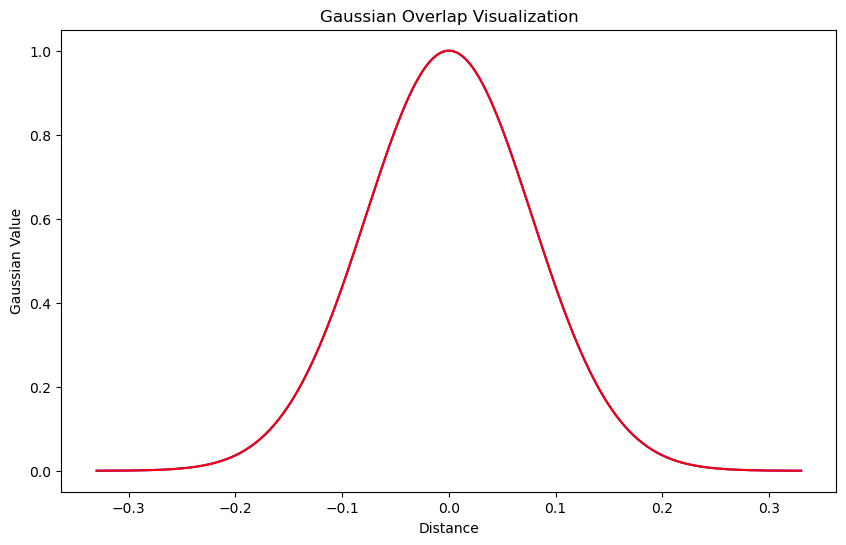

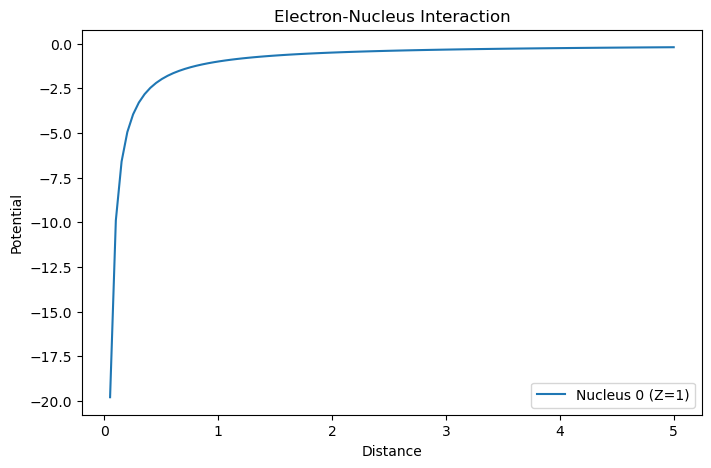

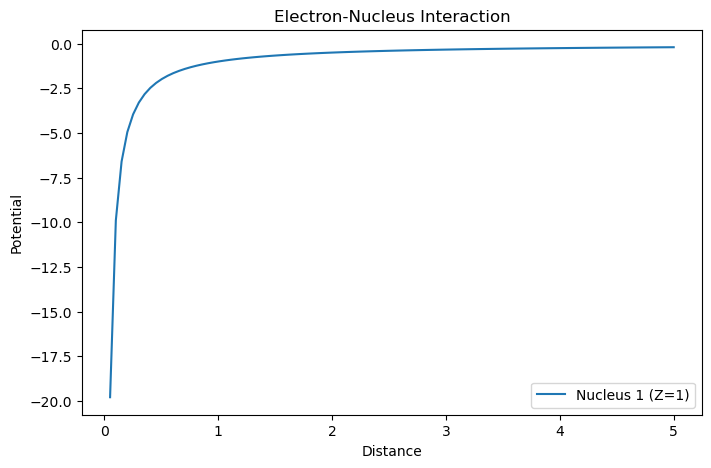

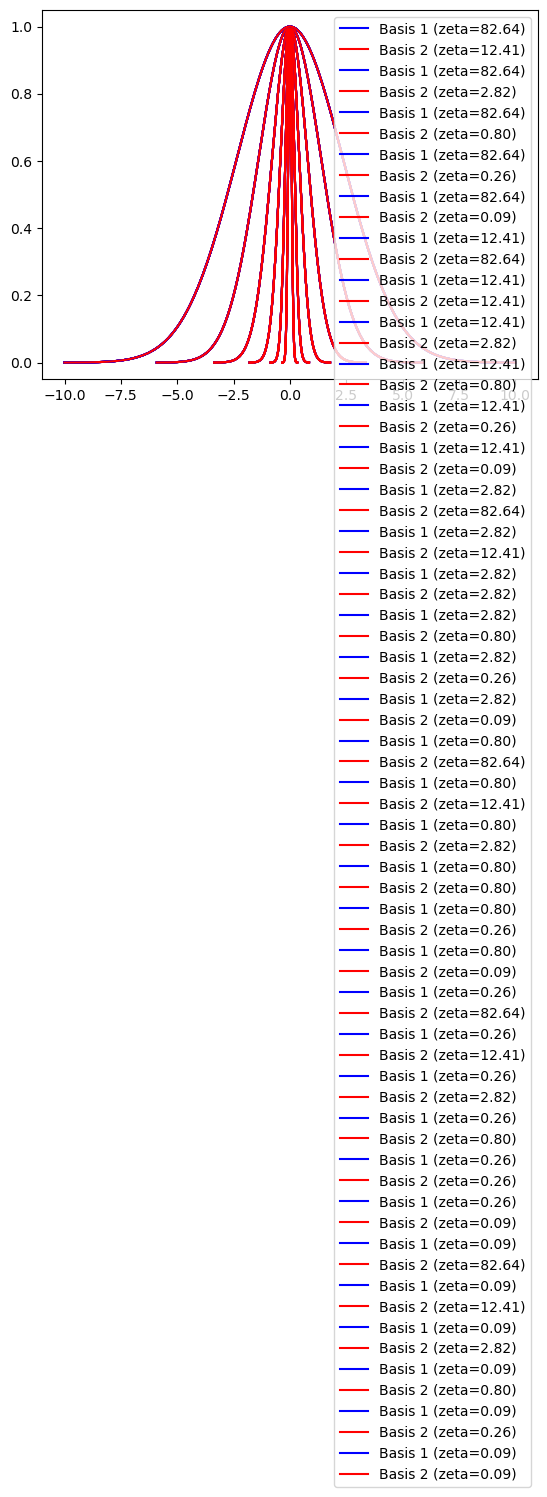

Iteration 1: E_elec = -2.513656439411954
Iteration 2: E_elec = -1.7702706570065287
Iteration 3: E_elec = -1.8220683380469733
Iteration 4: E_elec = -1.82848818791847
Iteration 5: E_elec = -1.8293282764040886
Iteration 6: E_elec = -1.8294397852457283
Iteration 7: E_elec = -1.829454661996232
Iteration 8: E_elec = -1.8294566525629974
Iteration 9: E_elec = -1.8294569194260804
SCF converged after 9 iterations
###########
E_elec: -1.8294569194260804 
-----------
ET: 1.0744128365968 
EV: -3.527391511988335 
EJ: 1.2470434291603993 
EK: -0.6235217145801952 
ENuc: 0.7248010010957404 
E_Elec + ENuc: -1.10465591833034 
>>> E(RHF): -1.1046559597155905  <<<


In [10]:
# Reading input
natoms, charge, labels, z, coords = ReadInput('inputs/h2.input')
#natoms, charge, labels, z, coords = ReadInput('heh+.input')
basis_set = "cc-pvqz"

# Building basis and computing 1 and 2 electron integrals
nb, basis = BuildBasis(natoms, z, coords, basis_set, basis_directory="basis/")
S, T, V = compute_one_electron_integrals(natoms,nb,z,coords,basis)
TEI = compute_two_electron_integrals(nb,coords,basis)
 
# Main execution
E_elec, P = scf(T, V, S, TEI, nb, charge)
ET, EV, EJ, EK, ENuc, ETot = energy_decomposition(P, T, V, TEI, z, coords, nb)

print("###########")
print("E_elec:", E_elec, "\n-----------")
print("ET:", ET, "\nEV:", EV, "\nEJ:", EJ, "\nEK:", EK, "\nENuc:", ENuc, "\nE_Elec + ENuc:", E_elec + ENuc, "\n>>> E(RHF):", ETot," <<<")